# Predicting Maternal Health Risk Using AI

This template provides a starting point to help you complete the project efficiently. 
You can use it as-is, modify it, or create your own structure; just be sure to complete all the required tasks.

# Install required packages
!pip install joblib
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow

## 1. Import required libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing - calibration 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV # (add Miranda)


# Machine Learning - Models
from sklearn.ensemble import RandomForestClassifier

# Machine Learning - Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, classification_report, confusion_matrix
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model persistence
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data preparation
### 2.1 Load the dataset

In [2]:
# Load the dataset
df = pd.read_csv('https://advanced-machine-learning-for-medical-data-8e1579.gitlab.io/labs/final_project/Maternal_Health_Risk_Data_Set_Modified.csv')


### 2.2 Initial data exploration

In [3]:
# Display basic information
print("Dataset dimensions:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print("\nColumn names and data types:")
print(df.dtypes)
print(df.head())

# Display statistical summary
df.describe()

Dataset dimensions:
Number of rows: 679
Number of columns: 8

Column names and data types:
CitizenID       object
Age            float64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate      float64
RiskLevel       object
dtype: object
  CitizenID   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  \
0      C001  25.0         130           80  15.0      98.0       86.0   
1      C002  35.0         140           90  13.0      98.0       70.0   
2      C003  29.0          90           70   8.0     100.0       80.0   
3      C004  30.0         140           85   7.0      98.0       70.0   
4      C005  35.0         120           60   6.1      98.0       76.0   

   RiskLevel  
0  high risk  
1  high risk  
2  high risk  
3  high risk  
4   low risk  


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,677.000000,679.000000,679.000000,679.000000,679.000000,677.000000
mean,30.584934,113.184094,77.550810,9.169779,98.585272,74.361891
std,13.882557,19.896709,14.817473,3.588331,1.334859,8.679393
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,95.000000,65.000000,7.000000,98.000000,70.000000
50%,27.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,40.000000,120.000000,90.000000,11.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [5]:
# Check for missing values
print(df.isnull().sum())

CitizenID      0
Age            2
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      2
RiskLevel      0
dtype: int64


In [6]:
# Check for duplicates
dup_rows = df.duplicated(keep=False)
print(f"\nNumber of duplicate rows: {dup_rows.sum()}")
if dup_rows.any():
    display(df[dup_rows])



Number of duplicate rows: 4


,CitizenID,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
7,C108,55.0,129,85,7.5,98.0,88.0,low risk
10,C176,17.0,90,63,8.0,101.0,70.0,high risk
70,C108,55.0,129,85,7.5,98.0,88.0,low risk
176,C176,17.0,90,63,8.0,101.0,70.0,high risk


In [7]:
# Check target variable distribution
class_counts = df['RiskLevel'].value_counts()
print("Class distribution (counts):")
print(class_counts )

# here inconsistent labels

Class distribution (counts):
RiskLevel
low risk     404
high risk    271
Low risk       3
HIGH risk      1
Name: count, dtype: int64


### 2.3 Data cleaning
#### Remove duplicates

In [8]:
# Remove duplicate rows
# keep first occurrence
df_clean = df.drop_duplicates(keep='first')

# Check into variable
dup_check = df_clean.duplicated(keep=False)
print(f"\nCheck number of duplicate rows: {dup_check.sum()}")


Check number of duplicate rows: 0


#### Remove Personally Identifiable Information (PII)

In [9]:
# Remove CitizenID column (PII)
df_clean = df_clean.drop(columns=["CitizenID"])

print(df_clean.columns.tolist())

['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']


#### Standardize risk level labels

In [10]:
# Standardize risk level labels (handle case variations)

#Inconsistencies
df_clean["RiskLevel_rp"] = df_clean["RiskLevel"].replace({
    "Low risk": "low risk",
    "HIGH risk": "high risk"
})

#count again
class_counts = df_clean['RiskLevel_rp'].value_counts()

print("Class distribution (counts) Standardize risk level labels :")
print(class_counts)

# Calculate the percentage of each class
class_percentages = df_clean['RiskLevel_rp'].value_counts(normalize=True) * 100
print("\nDistribution of Risk (percentages):")

for class_label, percentage in class_percentages.items():
    print(f"  Class {class_label}: {percentage:.2f}%")


Class distribution (counts) Standardize risk level labels :
RiskLevel_rp
low risk     406
high risk    271
Name: count, dtype: int64

Distribution of Risk (percentages):
  Class low risk: 59.97%
  Class high risk: 40.03%


#### Handle missing values

In [11]:
# Impute missing values with median for numerical columns

# Column names and data types:
# CitizenID       object
# Age            float64
# SystolicBP       int64
# DiastolicBP      int64
# BS             float64
# BodyTemp       float64
# HeartRate      float64
# RiskLevel       object

num_cols = ["Age", "SystolicBP", "DiastolicBP","DiastolicBP","BS","BodyTemp","HeartRate",]



# Median imputation for numeric columns
for col in num_cols:
    avg_val = df_clean[col].mean()
    df_clean[col] = df_clean[col].fillna(avg_val)
    print(f"Imputed {col} with median = {avg_val}")



Imputed Age with median = 30.56888888888889
Imputed SystolicBP with median = 113.19497784342688
Imputed DiastolicBP with median = 77.56129985228951
Imputed DiastolicBP with median = 77.56129985228951
Imputed BS with median = 9.17397341211226
Imputed BodyTemp with median = 98.58257016248153
Imputed HeartRate with median = 74.34814814814816


In [12]:
# check uniques values per columns
for col in num_cols:
    if col in df_clean.columns:
        unique_values = df_clean[col].unique()
        print(f"Unique values for column '{col}':")
        print(unique_values)
        print("-" * 20)
    else:
        print(f"Column '{col}' not found in DataFrame.")


Unique values for column 'Age':
[25.         35.         29.         30.         23.         55.
 17.         15.         50.         10.         40.         21.
 18.         16.         19.         22.         49.         28.
 20.         12.         60.         45.         32.         42.
 48.         34.         38.         39.         63.         54.
 14.         37.         30.56888889 33.         13.         31.
 51.         62.         43.         65.         66.         56.
 70.         36.         27.         59.         24.         41.
 46.        ]
--------------------
Unique values for column 'SystolicBP':
[130 140  90 120  85 129 110  70 100  75  95  76  80 135 160  83  99  78]
--------------------
Unique values for column 'DiastolicBP':
[ 80  90  70  85  60  89  63 100  50  65  75  95  49  69  76  68]
--------------------
Unique values for column 'DiastolicBP':
[ 80  90  70  85  60  89  63 100  50  65  75  95  49  69  76  68]
--------------------
Unique values for column 

In [13]:
# Print zero Nan 
print("\nMissing values after imputation:")
print(df_clean[num_cols].isnull().sum())


Missing values after imputation:
Age            0
SystolicBP     0
DiastolicBP    0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
dtype: int64


#### Data normalization (for visualization purposes)

In [40]:
# Create a normalized copy for visualization
df_normalized = df_clean.copy()
feature_cols = [col for col in num_cols if col in df_normalized.columns]
# Min-Max normalization for visualization
for col in feature_cols:     
    min_val = df_normalized[col].min()
    max_val = df_normalized[col].max()
    
df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)
print("Data normalized for visualization")
print("\nNormalized data summary:")
df_normalized[feature_cols].describe()




Data normalized for visualization

Normalized data summary:


,Age,SystolicBP,DiastolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000,677.000000
mean,30.568889,113.194978,77.561300,77.561300,9.173973,98.582570,0.811423
std,13.840894,19.896859,14.826048,14.826048,3.592777,1.333409,0.104360
min,10.000000,70.000000,49.000000,49.000000,6.000000,98.000000,0.000000
25%,19.000000,95.000000,65.000000,65.000000,7.000000,98.000000,0.759036
50%,27.000000,120.000000,80.000000,80.000000,7.500000,98.000000,0.831325
75%,40.000000,120.000000,90.000000,90.000000,11.000000,98.000000,0.879518
max,70.000000,160.000000,100.000000,100.000000,19.000000,103.000000,1.000000


### 2.4 Exploratory data analysis (EDA)

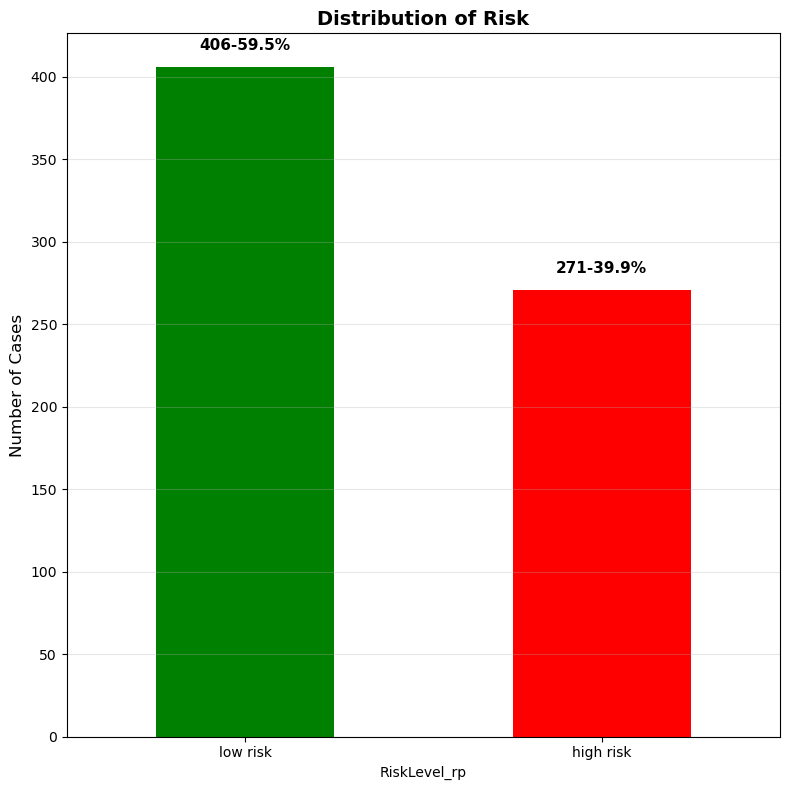

In [15]:
# Visualize target variable distribution

# Calculate the percentage of each class
class_percentages = df_clean['RiskLevel'].value_counts(normalize=True) * 100

    
plt.figure(figsize=(8, 8))
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Risk', fontsize=14, fontweight='bold')

plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars for clarity
for i, (count, pct) in enumerate(zip(class_counts, class_percentages)):
    plt.text(i, count + 10, f'{count}-' f'{pct:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Patient risk scoring - Random Forest model
### 3.1 Prepare data for modeling

In [16]:
# Identify features and target

# Separate features (X) from the target variable (y)
to_drop = [col for col in df_clean.columns if col.endswith('_scaled')] + ['RiskLevel',"RiskLevel_rp"]

# coding labels
df_clean["RiskLevel_rp"] = df_clean["RiskLevel_rp"].replace({
    "low risk": 0,
    "high risk": 1
})

X = df_clean.drop(columns=to_drop)  # All measurement columns
y = df_clean['RiskLevel_rp']  # Only the risk column



### 3.2 Train-Test split (DO NOT scale for Random Forest)

In [17]:
# Train-Test split with stratification

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


In [18]:
#X_train, X_test, y_train, y_test =
# Print number of samples
print("Number of training samples:", X_train.shape[0])
print("Number of test samples:", X_test.shape[0])
#Check number of features
print("Number of features:", X_train.shape[1])

# Check class distribution in train/test sets
print("\nTraining set class distribution:\n", y_train.value_counts())
print("\nTest set class distribution:\n", y_test.value_counts())


Number of training samples: 541
Number of test samples: 136
Number of features: 6

Training set class distribution:
 RiskLevel_rp
0    324
1    217
Name: count, dtype: int64

Test set class distribution:
 RiskLevel_rp
0    82
1    54
Name: count, dtype: int64


### 3.3 Train Random Forest model

In [19]:
# Initialize and train Random Forest Classifier

baseline_model = RandomForestClassifier(
    
    n_estimators=100,      # number of trees
    max_depth=None,        # let trees expand fully unless limited
    random_state=42,       # for reproducibility
    n_jobs=-1              # use all processors
)

baseline_model.fit(X_train, y_train)



RandomForestClassifier(n_jobs=-1, random_state=42)

### 3.4 Model evaluation

In [20]:
# Make predictions

#Predictions using Random Forest
predicted_values = baseline_model.predict(X_test)



# Predicted class labels
original_values = y_test

# Calculate metrics and Display metrics

print("\n Model Accuracy:", accuracy_score(original_values, predicted_values))




 Model Accuracy: 0.9411764705882353


In [21]:
# Detailed classification report

print("\n Classification Report:\n", classification_report(original_values, predicted_values, target_names=['Low Risk', 'High Rusk']))



 Classification Report:
               precision    recall  f1-score   support

    Low Risk       0.97      0.93      0.95        82
   High Rusk       0.90      0.96      0.93        54

    accuracy                           0.94       136
   macro avg       0.94      0.94      0.94       136
weighted avg       0.94      0.94      0.94       136



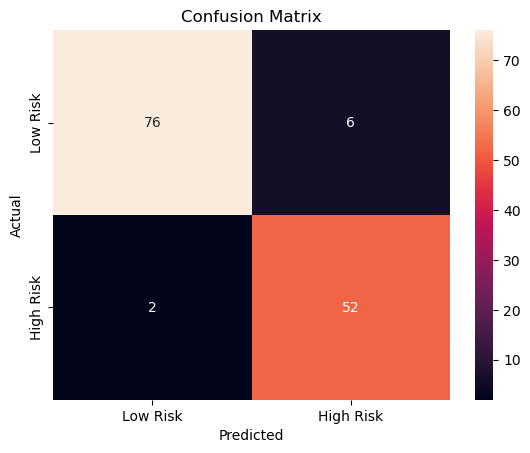

In [22]:
# Confusion Matrix
cm = confusion_matrix(original_values, predicted_values)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Low Risk", "High Risk"],
            yticklabels=["Low Risk", "High Risk"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




### 3.5 ROC-AUC curve

ROC-AUC: 0.990


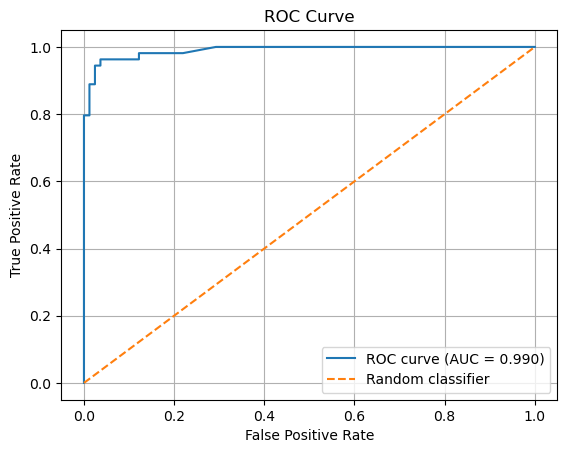

In [23]:
# Calculate ROC curve


#use crossvalidation avoiding overfitting

calibrated_model = CalibratedClassifierCV(
    baseline_model,
    method="isotonic",
    cv=5 # 5 folds
)

calibrated_model.fit(X_train, y_train)

# probabilility, return a matrix how many brenchs have class 1 or 0

y_pred_proba = calibrated_model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC-AUC: {roc_auc:.3f}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 3.6 Feature importance

In [24]:
# Get feature importances

feature_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance': baseline_model.feature_importances_,
}).sort_values('importance', ascending=False)
feature_importances.head()


,feature,importance
3,BS,0.460965
1,SystolicBP,0.227106
2,DiastolicBP,0.099852
0,Age,0.095091
4,BodyTemp,0.062066


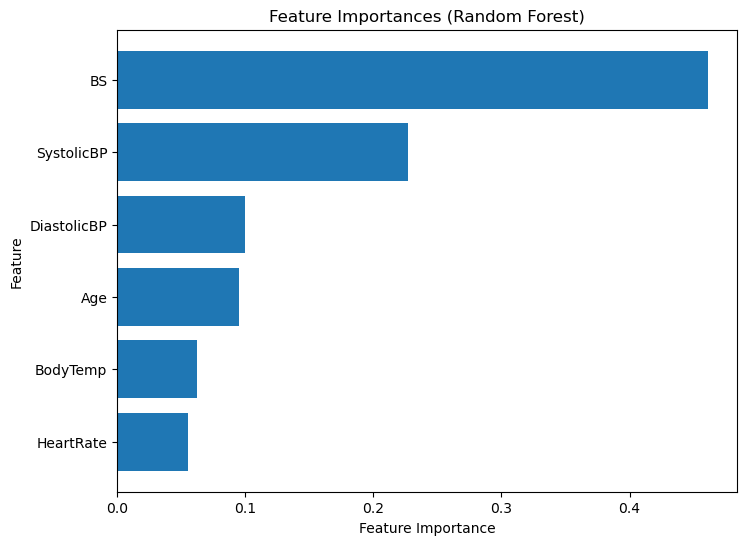

In [25]:
# Visualize feature importances

plt.figure(figsize=(8, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.gca().invert_yaxis()  # Most important at the top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Random Forest)')
plt.show()


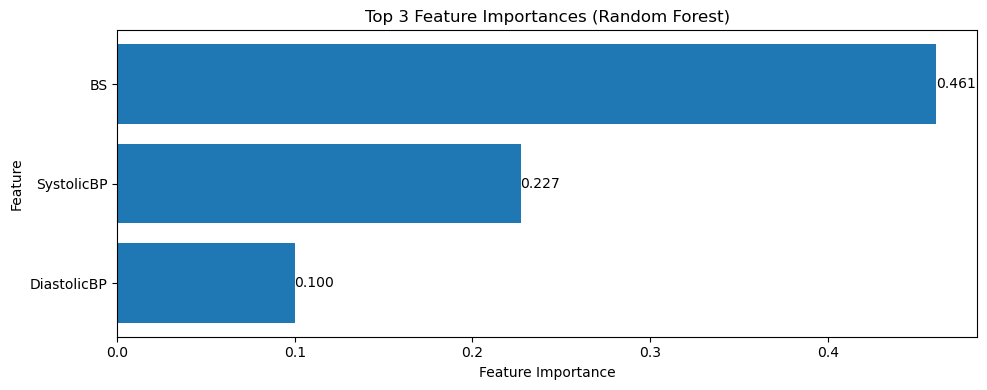

In [26]:
top_n = 3
fi_top = feature_importances.head(top_n)

plt.figure(figsize=(10, 4))
plt.barh(fi_top['feature'], fi_top['importance'])
plt.gca().invert_yaxis()

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 3 Feature Importances (Random Forest)')

# Add numeric values to bars
for index, value in enumerate(fi_top['importance']):
    plt.text(
        value,              # x-position
        index,              # y-position
        f'{value:.3f}',     # formatted value
        va='center',
        ha='left'
    )

plt.tight_layout()
plt.show()

### 3.7 Save Random Forest model

In [27]:
# Save the trained Random Forest model

# Define the filename for the saved model
model_random_forest = 'rf_risk_classifier_model.pkl'

# Save the model to disk using joblib
joblib.dump(baseline_model, model_random_forest)

print(f"Model saved successfully as '{model_random_forest}'!")


Model saved successfully as 'rf_risk_classifier_model.pkl'!


## 4. Dense neural network model
### 4.1 Scale data for neural network

In [28]:
# Apply StandardScaler
scaler = StandardScaler()
scaled_columns = [col + '_scaled' for col in num_cols]
df_clean[scaled_columns] = scaler.fit_transform(df_clean[num_cols])

# Separate features (X) from the target variable (y)
# select columns scaled
to_drop = [col for col in df_clean.columns if not col.endswith('_scaled')]+ ['RiskLevel',"RiskLevel_rp"]

X = df_clean.drop(columns=to_drop)  # All measurement columns
y = df_clean['RiskLevel_rp']  # Only the diagnosis column

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)


### 4.2 Build dense neural network architecture

In [29]:
# Build neural network model
model_nn = keras.Sequential([
    # Input layer: accepts 6 features
    layers.Input(shape=(6,)),   
    
    # First hidden layer: 16 neurons with ReLU activation
    # ReLU helps the model learn complex patterns by focusing on positive signals
    layers.Dense(16, activation="relu"),       
    
    # Second hidden layer: 8 neurons with ReLU activation
    # Further refines the learned patterns
    layers.Dense(8, activation="relu"),        
    
    # Output layer: 1 neuron with sigmoid activation
    # Sigmoid produces a probability between 0 and 1 for binary classification
    layers.Dense(1, activation="sigmoid")      
])


# Compile the model
model_nn.compile(
    # Loss function: measures prediction error for binary classification
    loss="binary_crossentropy",
    
    # Optimizer: algorithm that updates model weights to minimize loss
    optimizer="adam",
    
    # Metrics: tracks accuracy (percentage of correct predictions)
    metrics=["accuracy"]
)


### 4.3 Train neural network model

In [30]:
# Train the model

history = model_nn.fit(
    # Training features and labels
    X_train, 
    y_train,
    
    # Validation data to monitor performance on unseen data
    validation_data=(X_test, y_test),
    
    # Number of complete passes through the training data
    epochs=50,
    
    # Number of samples processed before updating weights
    batch_size=32,
    
    # Show progress bar during training
    verbose=1
)




Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6081 - loss: 0.7101 - val_accuracy: 0.6838 - val_loss: 0.6869
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7061 - loss: 0.6635 - val_accuracy: 0.7500 - val_loss: 0.6449
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7708 - loss: 0.6241 - val_accuracy: 0.8015 - val_loss: 0.6076
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8226 - loss: 0.5873 - val_accuracy: 0.8088 - val_loss: 0.5713
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8392 - loss: 0.5505 - val_accuracy: 0.8309 - val_loss: 0.5315
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8503 - loss: 0.5111 - val_accuracy: 0.8309 - val_loss: 0.4857
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8577 - loss: 0.4629 - val_accuracy: 0.8456 - val_loss: 0.4309
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8669 - loss: 0.4090 - val_accuracy: 0.8456 - val_loss

### 4.4 Visualize training history

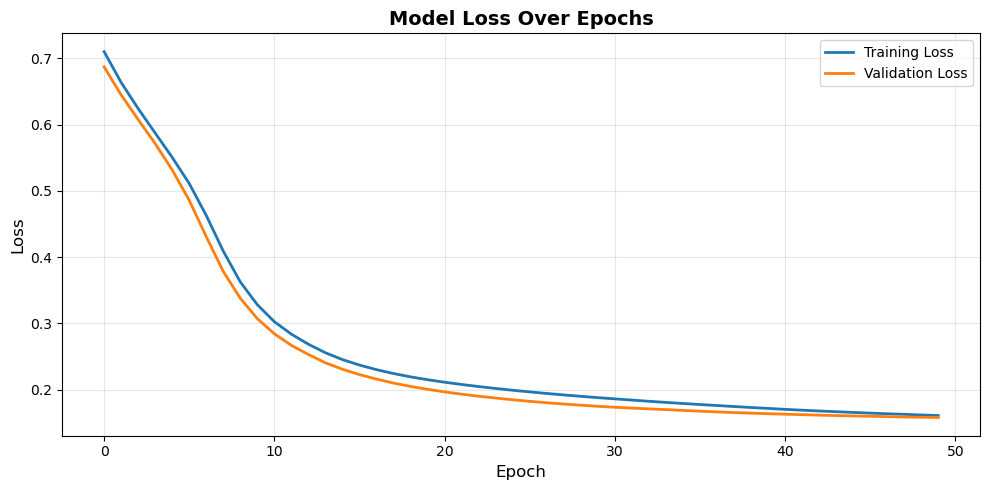

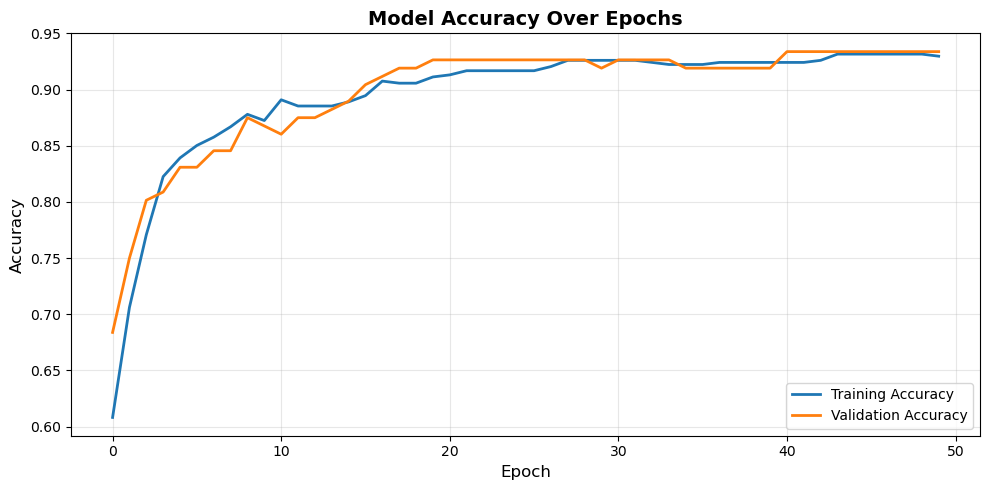

In [31]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(history.history["loss"], label="Training Loss", linewidth=2)

# Plot validation loss
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)

plt.title("Model Loss Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Plot training accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy", linewidth=2)

# Plot validation accuracy
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2)

plt.title("Model Accuracy Over Epochs", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





### 4.5 Evaluate neural network model

In [32]:
# Make predictions
y_pred_prob = model_nn.predict(X_test)

# Calculate metrics

# Convert probabilities to binary predictions using 0.5 threshold
# If probability > 0.5, predict 1 (High Risk ); otherwise predict 0 (Low Risk)
y_pred = (y_pred_prob > 0.5).astype(int)



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [33]:
# Detailed classification report

print("Classification Report Neural Network:")
print("="*60)
print(classification_report(y_test, y_pred))


Classification Report Neural Network:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94        82
           1       0.91      0.93      0.92        54

    accuracy                           0.93       136
   macro avg       0.93      0.93      0.93       136
weighted avg       0.93      0.93      0.93       136



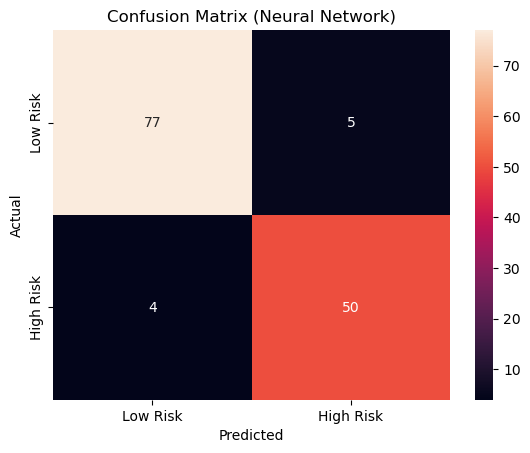

In [34]:
# Confusion matrix for neural network


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Low Risk", "High Risk"],
            yticklabels=["Low Risk", "High Risk"])
plt.title("Confusion Matrix (Neural Network)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### 4.6 Save neural network model

In [ ]:
# Save the trained neural network model
model_nn.save("trained_model_nn.keras")

# Load
#model_nn = keras.models.load_model("trained_model_nn.keras")


## 5. Model comparison

In [35]:
# Compare model performance

report_baseline = classification_report(
    original_values, predicted_values, output_dict=True
)

report_nn = classification_report(
    y_test, y_pred, output_dict=True
)

df_baseline = pd.DataFrame(report_baseline).T
df_nn = pd.DataFrame(report_nn).T

df_compare = df_baseline.merge(
    df_nn,
    left_index=True,
    right_index=True,
    suffixes=('_baseline', '_nn')
)


df_compare




,precision_baseline,recall_baseline,f1-score_baseline,support_baseline,precision_nn,recall_nn,f1-score_nn,support_nn
0,0.974359,0.926829,0.950000,82.000000,0.950617,0.939024,0.944785,82.000000
1,0.896552,0.962963,0.928571,54.000000,0.909091,0.925926,0.917431,54.000000
accuracy,0.941176,0.941176,0.941176,0.941176,0.933824,0.933824,0.933824,0.933824
macro avg,0.935455,0.944896,0.939286,136.000000,0.929854,0.932475,0.931108,136.000000
weighted avg,0.943465,0.941176,0.941492,136.000000,0.934129,0.933824,0.933924,136.000000


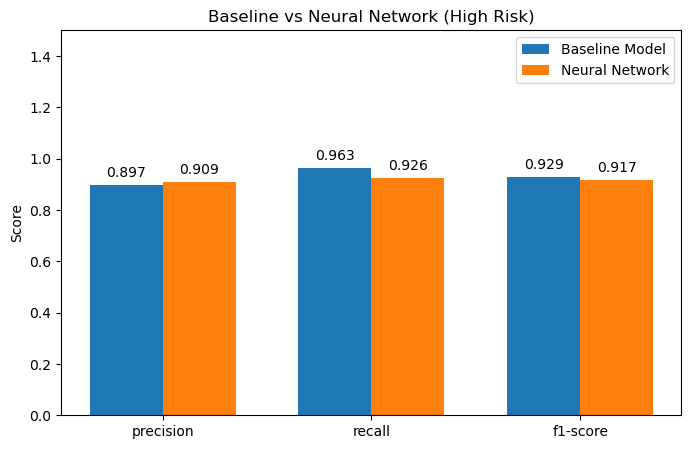

In [36]:
metric_names = ['precision', 'recall', 'f1-score']
class_label = '1'

baseline_vals = df_compare.loc[
    class_label, [f'{m}_baseline' for m in metric_names]
]

nn_vals = df_compare.loc[
    class_label, [f'{m}_nn' for m in metric_names]
]

x = np.arange(len(metric_names))
width = 0.35

plt.figure(figsize=(8, 5))

bars1 = plt.bar(
    x - width/2,
    baseline_vals,
    width,
    label='Baseline Model'
)

bars2 = plt.bar(
    x + width/2,
    nn_vals,
    width,
    label='Neural Network'
)

plt.xticks(x, metric_names)
plt.ylabel('Score')
plt.ylim(0, 1.5)
plt.title('Baseline vs Neural Network (High Risk)')
plt.legend()
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.02,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=10
        )

add_labels(bars1)
add_labels(bars2)

plt.show()
